## cnn + transformer to handle spatial and temporal information

### draft scripts

In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class VideoRegressionModel(nn.Module):
    def __init__(self, num_frames, num_channels, patch_size, hidden_dim, num_layers, num_heads, mlp_dim, output_dim):
        super(VideoRegressionModel, self).__init__()
        self.num_frames = num_frames
        self.num_channels = num_channels
        self.patch_size = patch_size
        
        # ResNet34 as the CNN for feature extraction
        self.cnn = resnet34()
        self.cnn.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn.fc = nn.Identity()  # Remove the last fully connected layer
        
        # Vision Transformer for temporal modeling
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, 
                                          dim_feedforward=mlp_dim, dropout=0.1, activation='relu', batch_first=True)

        # Regression head
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(2)  # increase dimension for grayscale channel
        # print(x.shape)

        # Extract features using ResNet34
        features = []
        for i in range(self.num_frames):
            frame_features = self.cnn(x[:, i])
            features.append(frame_features)
        features = torch.stack(features, dim=1)
        # print(features.shape)

        # Pass features through the Transformer
        outputs = self.transformer(features, features)
        # print(transformer_output.shape)
        
        # Take the mean of the Transformer output along the time dimension, act as pooling layer
        outputs = outputs.mean(dim=1) 
        # print(transformer_output.shape)
        
        # Pass the Transformer output through the regression head
        outputs = self.fc(outputs)
        # print(output.shape)
        return outputs
    
model = VideoRegressionModel(num_frames=128, num_channels=1, patch_size=16, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)
input_data = torch.randn(2, 128, 250, 400)
output = model(input_data)
print(output.shape)  # Should be (batch_size, output_dim)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/benchmark')
from train_functions import train_epochs
from utils import split_train_valid, viz_dataloader
from viz import show_images

In [ ]:
import h5py
with h5py.File('../../../datasets/growth_rate_regression_ds.h5', 'r') as h5:
    print(h5.keys())
    for key in h5.keys():
        print(key, h5[key].shape, h5[key].dtype)
    images = np.array(h5['plumes'][:10, :32])
    labels = np.array(h5['growth_rate(angstrom_per_pulse)'][:10])
show_images(images[0])
print(labels)

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/benchmark')
from train_functions import train_epochs
from utils import split_train_valid, viz_dataloader
from viz import show_images

class hdf5_dataset(Dataset):
    
    def __init__(self, file_path, folder=None, transform=None, data_key='data', label_key='labels'):
        self.file_path = file_path
        self.folder = folder
        self.transform = transform
        self.hf = None
        self.data_key = data_key
        self.label_key = label_key

    def __len__(self):
        with h5py.File(self.file_path, 'r') as f:
            if self.folder:
                self.len = len(f[self.folder][self.label_key])
            else:
                self.len = len(f[self.label_key])
        return self.len
    
    def __getitem__(self, idx):
        if self.hf is None:
            self.hf = h5py.File(self.file_path, 'r')
        
        if self.folder:
            video = np.array(self.hf[self.folder][self.data_key][idx])
            label = np.array(self.hf[self.folder][self.label_key][idx])
        else:
            video = np.array(self.hf[self.data_key][idx])
            label = np.array(self.hf[self.label_key][idx])
            
        # Convert numpy array to a list of PIL Images
        if video.dtype != np.uint8:
            video = (video * 255).astype(np.uint8)
        
        video_frames = []
        for frame in video:
            if frame.ndim == 2:  # If it's a grayscale image
                frame = Image.fromarray(frame, mode='L')
            else:
                frame = Image.fromarray(frame)
            video_frames.append(frame)
        
        if self.transform:
            video_frames = [self.transform(frame) for frame in video_frames]
            video_frames = torch.stack(video_frames)
            # Remove the following line to keep the shape as [128, 250, 400]
            # if video_frames.ndim == 3:
            #     video_frames = video_frames.unsqueeze(1)  # expand dimension for single channel video
            video_frames = video_frames.squeeze()  # expand dimension for single channel video

        return video_frames, torch.tensor(label)

In [ ]:
whole_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
image, label = whole_ds[0]
print(image.shape, label)

bs = 2
num_workers = 0

# imagenet
whole_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
train_ds, valid_ds = split_train_valid(whole_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape)

model = VideoRegressionModel(num_frames=128, num_channels=1, patch_size=16, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)
output = model(images)
print(output.shape)  # Should be (batch_size, output_dim)

In [ ]:
loss_func = nn.MSELoss()
                   
loss = loss_func(output, labels)
print(loss.item())

In [ ]:
loss

### packed function for training

In [1]:
import h5py
import os
import time
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision import datasets, transforms, models
import matplotlib.image as image

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/benchmark')
from utils import split_train_valid, viz_dataloader
from viz import show_images

class hdf5_dataset(Dataset):
    
    def __init__(self, file_path, folder=None, transform=None, data_key='data', label_key='labels'):
        self.file_path = file_path
        self.folder = folder
        self.transform = transform
        self.hf = None
        self.data_key = data_key
        self.label_key = label_key

    def __len__(self):
        with h5py.File(self.file_path, 'r') as f:
            if self.folder:
                self.len = len(f[self.folder][self.label_key])
            else:
                self.len = len(f[self.label_key])
        return self.len
    
    def __getitem__(self, idx):
        if self.hf is None:
            self.hf = h5py.File(self.file_path, 'r')
        
        if self.folder:
            video = np.array(self.hf[self.folder][self.data_key][idx])
            label = np.array(self.hf[self.folder][self.label_key][idx])
        else:
            video = np.array(self.hf[self.data_key][idx])
            label = np.array(self.hf[self.label_key][idx])
            
        # Convert numpy array to a list of PIL Images
        if video.dtype != np.uint8:
            video = (video * 255).astype(np.uint8)
        
        video_frames = []
        for frame in video:
            if frame.ndim == 2:  # If it's a grayscale image
                frame = Image.fromarray(frame, mode='L')
            else:
                frame = Image.fromarray(frame)
            video_frames.append(frame)
        
        if self.transform:
            video_frames = [self.transform(frame) for frame in video_frames]
            video_frames = torch.stack(video_frames)
            # Remove the following line to keep the shape as [128, 250, 400]
            # if video_frames.ndim == 3:
            #     video_frames = video_frames.unsqueeze(1)  # expand dimension for single channel video
            video_frames = video_frames.squeeze()  # expand dimension for single channel video

        return video_frames, torch.tensor(label)

class VideoRegressionModel(nn.Module):
    def __init__(self, num_frames, num_channels, patch_size, hidden_dim, num_layers, num_heads, mlp_dim, output_dim):
        super(VideoRegressionModel, self).__init__()
        self.num_frames = num_frames
        self.num_channels = num_channels
        self.patch_size = patch_size
        
        # ResNet34 as the CNN for feature extraction
        self.cnn = resnet18()
        self.cnn.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn.fc = nn.Identity()  # Remove the last fully connected layer
        
        # Vision Transformer for temporal modeling
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, 
                                          dim_feedforward=mlp_dim, dropout=0.1, activation='relu', batch_first=True)

        # Regression head
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(2)  # increase dimension for grayscale channel
        # print(x.shape)

        # Extract features using ResNet34
        features = []
        for i in range(self.num_frames):
            frame_features = self.cnn(x[:, i])
            features.append(frame_features)
        features = torch.stack(features, dim=1)

        # Pass features through the Transformer
        outputs = self.transformer(features, features)
        
        # Take the mean of the Transformer output along the time dimension, act as pooling layer
        outputs = outputs.mean(dim=1) 
        
        # Pass the Transformer output through the regression head
        outputs = self.fc(outputs)
        return outputs
    

def train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl_list, valid_name_list,
                 epochs, start=0, scheduler=None, valid_every_epochs=1, accuracy=True, model_dir=None, save_per_epoch=1, tracking=False):
    
    if isinstance(valid_every_epochs, int) and valid_dl_list != []:
        valid_every_epochs = [valid_every_epochs]*len(valid_dl_list)
        
    elif isinstance(valid_every_epochs, list) and valid_dl_list == []:
        if len(valid_every_epochs) != len(valid_dl_list):
            raise ValueError("The length of valid_every_epochs should match the number of cross-validation datasets.")
    
    # make directory for the model
    if model_dir and not os.path.isdir(model_dir): 
        os.mkdir(model_dir)

    history = {'epoch':[], 'train_loss':[], 'valid_loss':[], 'train_acc':[], 'valid_acc':[]}
    if valid_dl_list != []:
        for cv_name in valid_name_list:
            history[cv_name+'_loss'] = []
        
    for epoch_idx in range(start, epochs+start):
                
        print("Epoch: {}/{}".format(epoch_idx+1, epochs+start))
        
        avg_train_loss = train(model, loss_func, optimizer, device, train_dl, 
                              scheduler=scheduler, tracking=tracking)
        print(f"Training: Loss: {avg_train_loss:.4f}")
        
        metadata = {'epoch': epoch_idx, 'train_loss': avg_train_loss}

        if valid_dl_list != []:
            for i, (cv_dl, cv_name) in enumerate(zip(valid_dl_list, valid_name_list)):
                if (epoch_idx+1) % valid_every_epochs[i] == 0: # the first element is for the validation set
                    avg_cv_loss = valid(model, loss_func, device, cv_dl, task_label=cv_name, tracking=tracking)
                    metadata[cv_name+'_loss'] = avg_cv_loss
                    print(f"{cv_name}: Loss: {avg_cv_loss:.4f}")

        if model_dir != None:
            if (epoch_idx+1) % save_per_epoch == 0:
                torch.save(model.cpu().state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch_idx+1)))

        # record the epoch loss and accuracy:
        for key, value in metadata.items():
            history[key].append(value)
                
    return history


def train(model, loss_func, optimizer, device, train_dl, scheduler=None, tracking=False):

    train_data_size = len(train_dl.dataset)
    start_time = time.time()

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0

    for i, batch in enumerate(tqdm(train_dl)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).float()
        model = model.to(device)

        # Clean existing gradients
        optimizer.zero_grad()

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_func(outputs, labels) 

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
        
        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()
        if scheduler:
            scheduler.step()

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 

    return avg_train_loss


def valid(model, loss_func, device, valid_dl, task_label='valid', tracking=False):

    valid_data_size = len(valid_dl.dataset)

    # Loss and Accuracy within the epoch
    valid_loss = 0.0
    valid_acc = 0.0
    
    start_time = time.time()
        
    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        
        for j, batch in enumerate(tqdm(valid_dl)):
            
            inputs = batch[0].float().to(device)
            labels = batch[1].long().to(device)

            model = model.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_func(outputs, labels) 
            
            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size 

    return avg_valid_loss

In [2]:
bs = 16
num_workers = 0

# imagenet
whole_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds_2_26frames_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
train_ds, valid_ds = split_train_valid(whole_ds, 0.9)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

test_ds = hdf5_dataset('../../../datasets/growth_rate_regression_ds_2_26frames_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='growth_rate(angstrom_per_pulse)')
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape)

model = VideoRegressionModel(num_frames=24, num_channels=1, patch_size=16, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)
output = model(images)
print(output.shape)  # Should be (batch_size, output_dim)

torch.Size([16, 24, 250, 400]) torch.Size([16, 1])
torch.Size([16, 1])


In [4]:
device = torch.device('cuda:0')
lr = 1e-5
start = 0
epochs = 200

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl_list=[valid_dl], valid_name_list=['validation'],
                       epochs=epochs, start=start, scheduler=scheduler, valid_every_epochs=1, save_per_epoch=10,
                       model_dir='../../../datasets/growth_rate_regression/', tracking=False)

Epoch: 1/200


  0%|          | 0/150 [00:00<?, ?it/s]c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 150/150 [01:42<00:00,  1.47it/s]


Training: Loss: 0.0161


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0490
Epoch: 2/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0073


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0654
Epoch: 3/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0072


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0514
Epoch: 4/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0064


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


validation: Loss: 0.0344
Epoch: 5/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0061


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0642
Epoch: 6/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0054


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0548
Epoch: 7/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0049


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


validation: Loss: 0.0301
Epoch: 8/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0045


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0283
Epoch: 9/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0041


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0248
Epoch: 10/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0039


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0179
Epoch: 11/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0035


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0132
Epoch: 12/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0032


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0128
Epoch: 13/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0030


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0121
Epoch: 14/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0029


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0160
Epoch: 15/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0026


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0208
Epoch: 16/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0025


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0173
Epoch: 17/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0024


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0072
Epoch: 18/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0020


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0143
Epoch: 19/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0019


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0129
Epoch: 20/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0019


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0077
Epoch: 21/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0017


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0109
Epoch: 22/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0017


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0075
Epoch: 23/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0016


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0154
Epoch: 24/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0015


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0085
Epoch: 25/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0013


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0085
Epoch: 26/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0013


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0080
Epoch: 27/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0012


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0113
Epoch: 28/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0010


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0148
Epoch: 29/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0011


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0106
Epoch: 30/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0010


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0089
Epoch: 31/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0010


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0078
Epoch: 32/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0008


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0058
Epoch: 33/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0009


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0117
Epoch: 34/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0007


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0108
Epoch: 35/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0008


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0073
Epoch: 36/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0006


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0090
Epoch: 37/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0006


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0086
Epoch: 38/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0007


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0043
Epoch: 39/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0006


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0057
Epoch: 40/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0007


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0083
Epoch: 41/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0006


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0036
Epoch: 42/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0005


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0056
Epoch: 43/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0005


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0077
Epoch: 44/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0004


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0084
Epoch: 45/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0005


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0027
Epoch: 46/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0004


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0065
Epoch: 47/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0005


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0111
Epoch: 48/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0003


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0056
Epoch: 49/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0004


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0047
Epoch: 50/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0003


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


validation: Loss: 0.0081
Epoch: 51/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0003


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0083
Epoch: 52/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0003


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0043
Epoch: 53/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0003


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0051
Epoch: 54/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0060
Epoch: 55/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0054
Epoch: 56/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0051
Epoch: 57/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0040
Epoch: 58/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0084
Epoch: 59/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0045
Epoch: 60/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0054
Epoch: 61/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0055
Epoch: 62/200


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


validation: Loss: 0.0027
Epoch: 63/200


100%|██████████| 150/150 [01:35<00:00,  1.56it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0058
Epoch: 64/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


validation: Loss: 0.0040
Epoch: 65/200


100%|██████████| 150/150 [01:36<00:00,  1.55it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0081
Epoch: 66/200


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0078
Epoch: 67/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0052
Epoch: 68/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:07<00:00,  2.39it/s]


validation: Loss: 0.0053
Epoch: 69/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0002


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0080
Epoch: 70/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0049
Epoch: 71/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0067
Epoch: 72/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0060
Epoch: 73/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0086
Epoch: 74/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0065
Epoch: 75/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0052
Epoch: 76/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0068
Epoch: 77/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0056
Epoch: 78/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0048
Epoch: 79/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


validation: Loss: 0.0060
Epoch: 80/200


100%|██████████| 150/150 [01:39<00:00,  1.51it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0051
Epoch: 81/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0061
Epoch: 82/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0085
Epoch: 83/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


validation: Loss: 0.0072
Epoch: 84/200


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0047
Epoch: 85/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0047
Epoch: 86/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0075
Epoch: 87/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


validation: Loss: 0.0046
Epoch: 88/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


validation: Loss: 0.0041
Epoch: 89/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0047
Epoch: 90/200


100%|██████████| 150/150 [01:38<00:00,  1.53it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0084
Epoch: 91/200


100%|██████████| 150/150 [01:39<00:00,  1.51it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


validation: Loss: 0.0067
Epoch: 92/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0073
Epoch: 93/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0072
Epoch: 94/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


validation: Loss: 0.0089
Epoch: 95/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0062
Epoch: 96/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0073
Epoch: 97/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


validation: Loss: 0.0062
Epoch: 98/200


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


Training: Loss: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


validation: Loss: 0.0068
Epoch: 99/200


100%|██████████| 150/150 [01:39<00:00,  1.51it/s]


Training: Loss: 0.0000


100%|██████████| 17/17 [00:07<00:00,  2.42it/s]


validation: Loss: 0.0073
Epoch: 100/200


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training: Loss: 0.0000


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


validation: Loss: 0.0073
Epoch: 101/200


 49%|████▊     | 73/150 [00:48<00:51,  1.51it/s]


KeyboardInterrupt: 

In [8]:
torch.save(model.cpu().state_dict(), 'growth_rate_regression_model.pt')

In [3]:
model = VideoRegressionModel(num_frames=24, num_channels=1, patch_size=16, hidden_dim=512, 
                             num_layers=4, num_heads=8, mlp_dim=2048, output_dim=1)

model.load_state_dict(torch.load('growth_rate_regression_model.pt'))

<All keys matched successfully>

c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


(16, 24, 250, 400) torch.Size([16, 1]) torch.Size([16, 1])


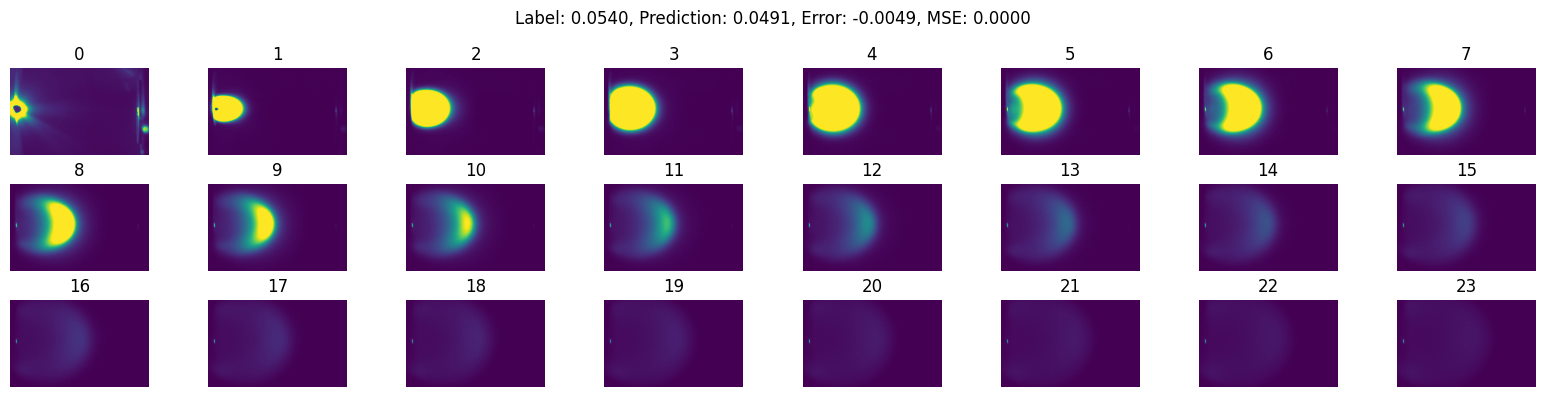

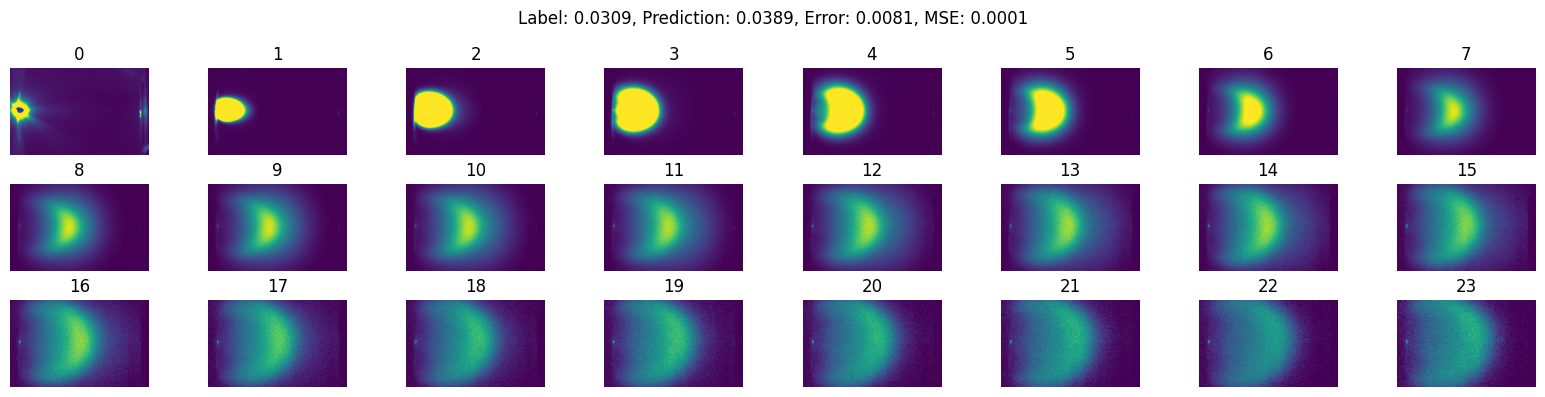

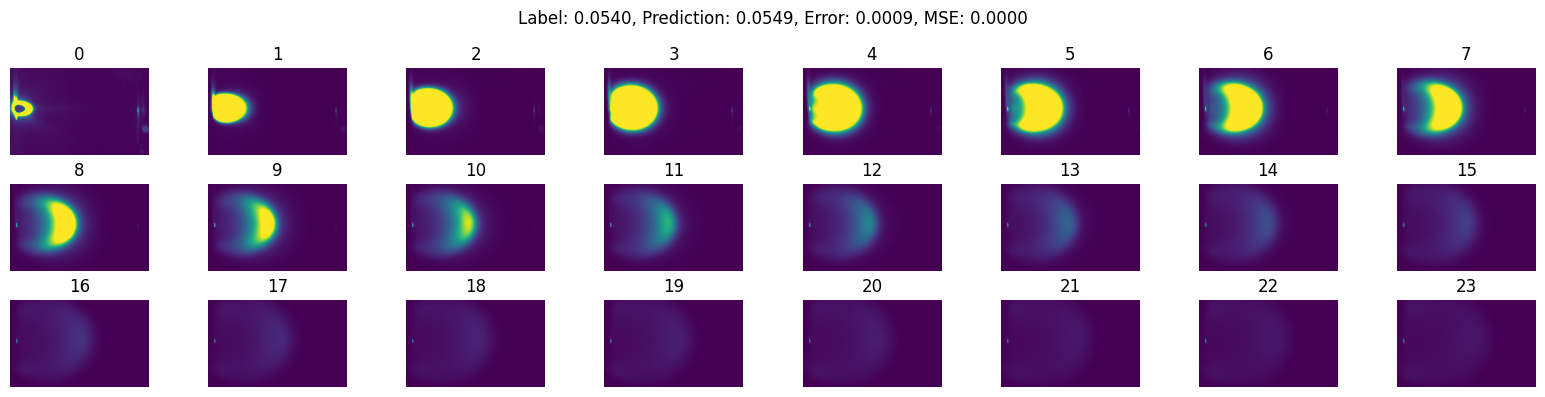

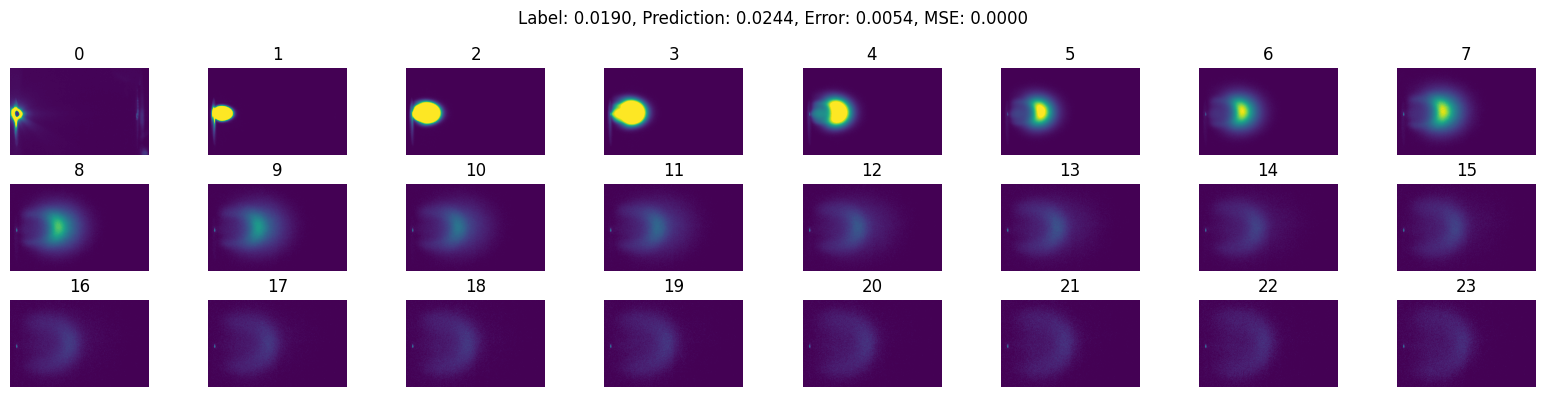

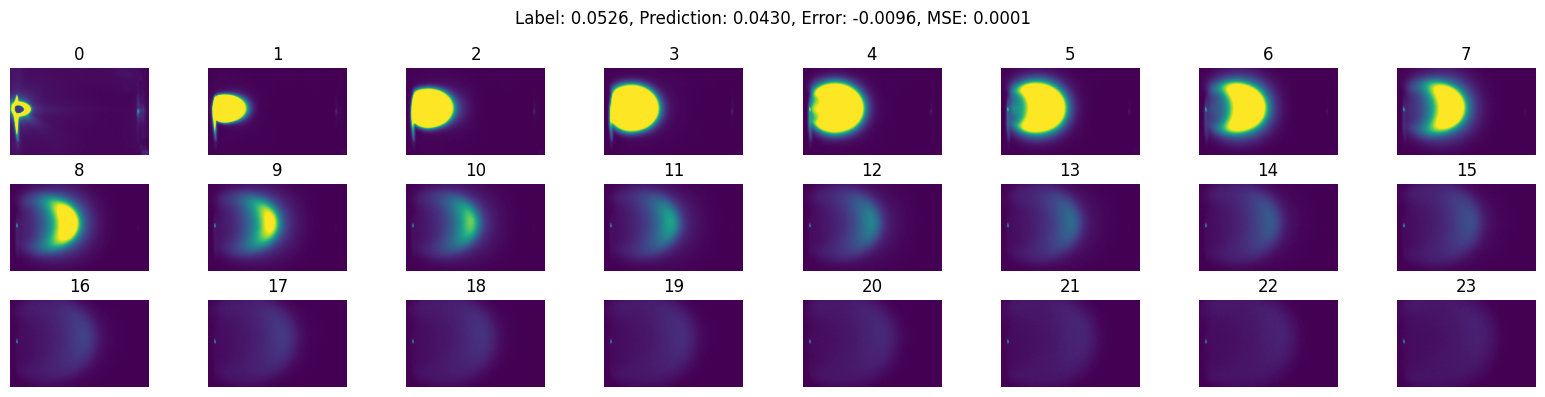

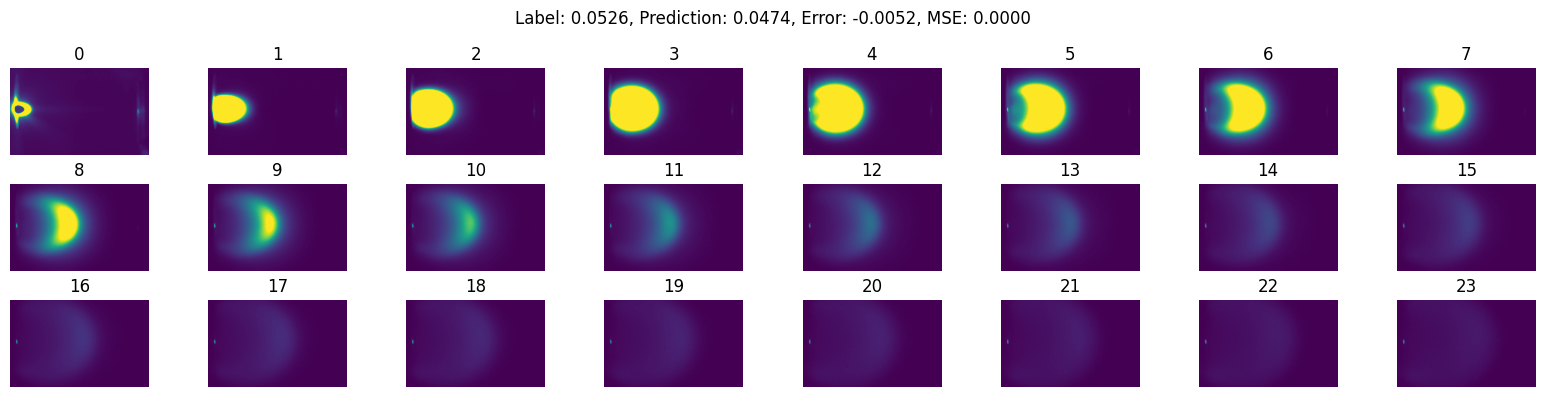

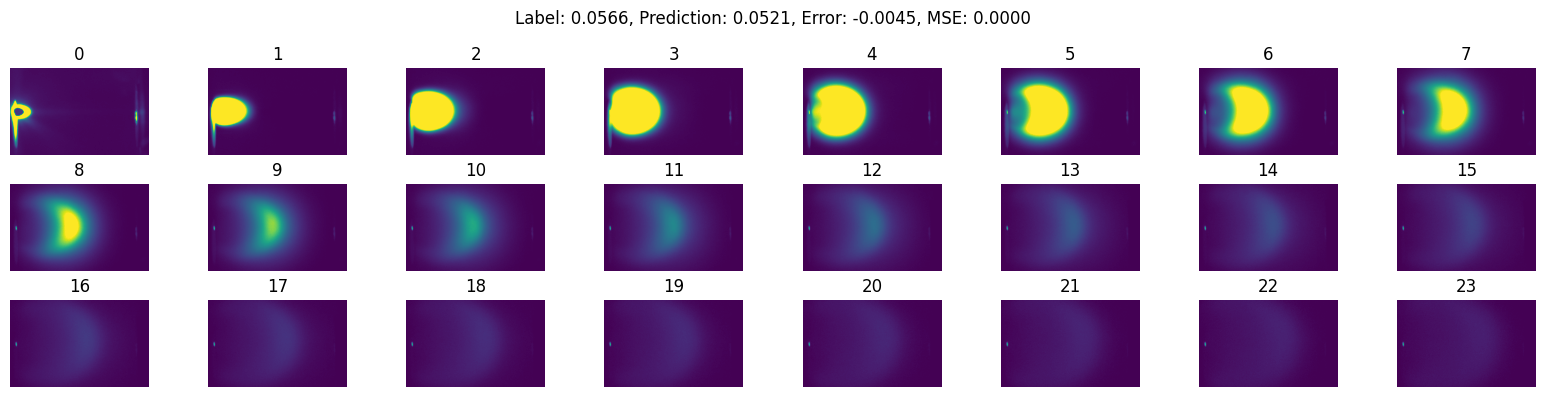

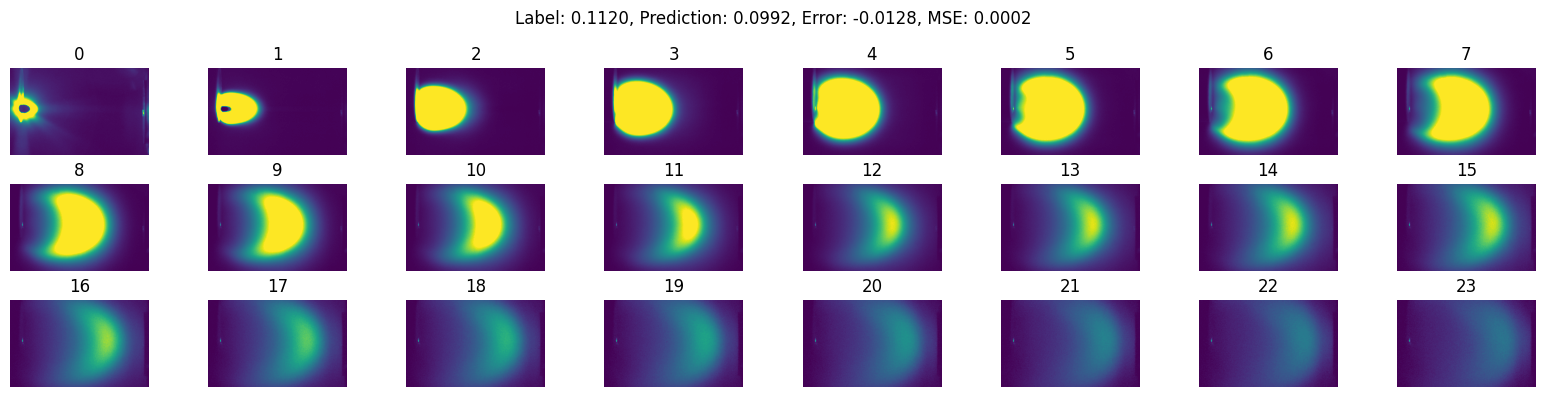

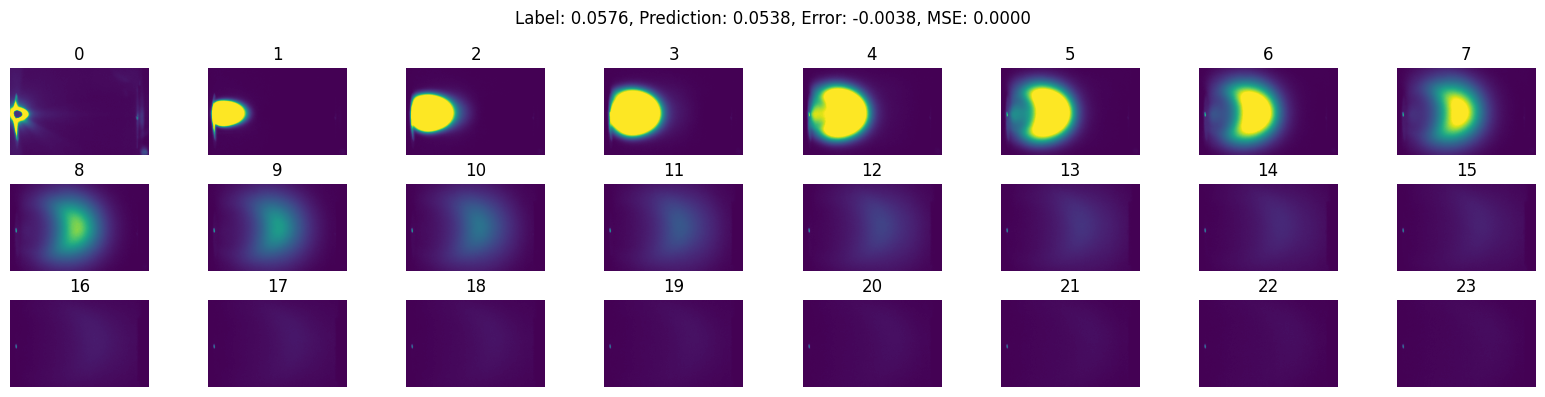

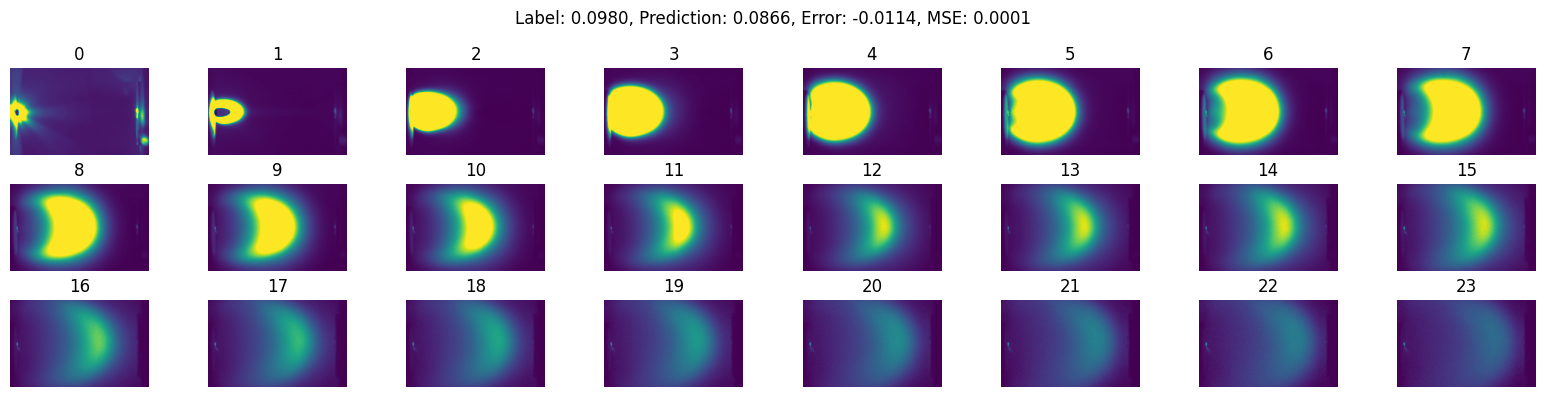

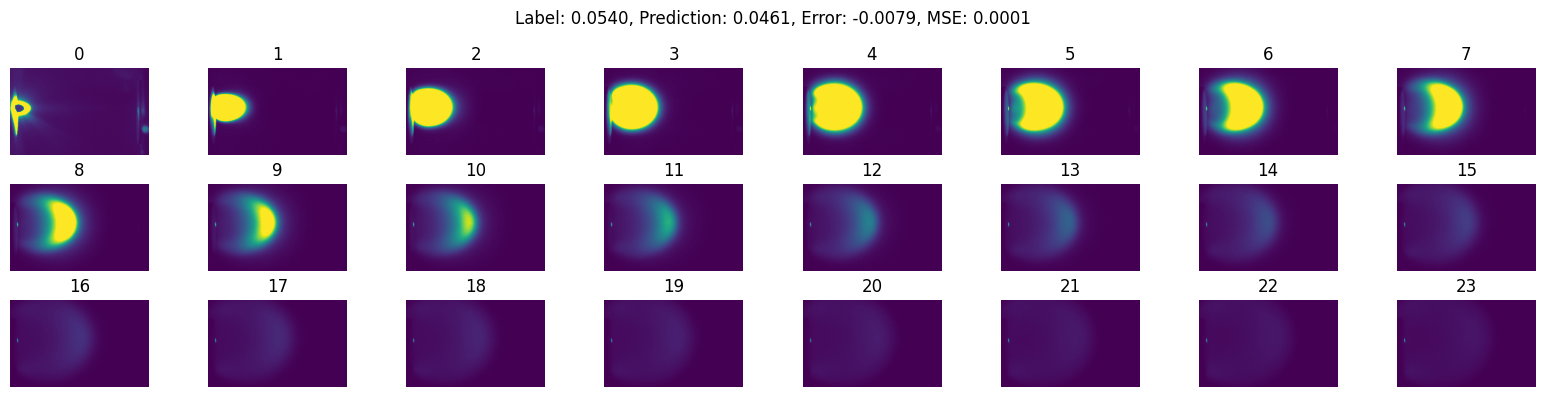

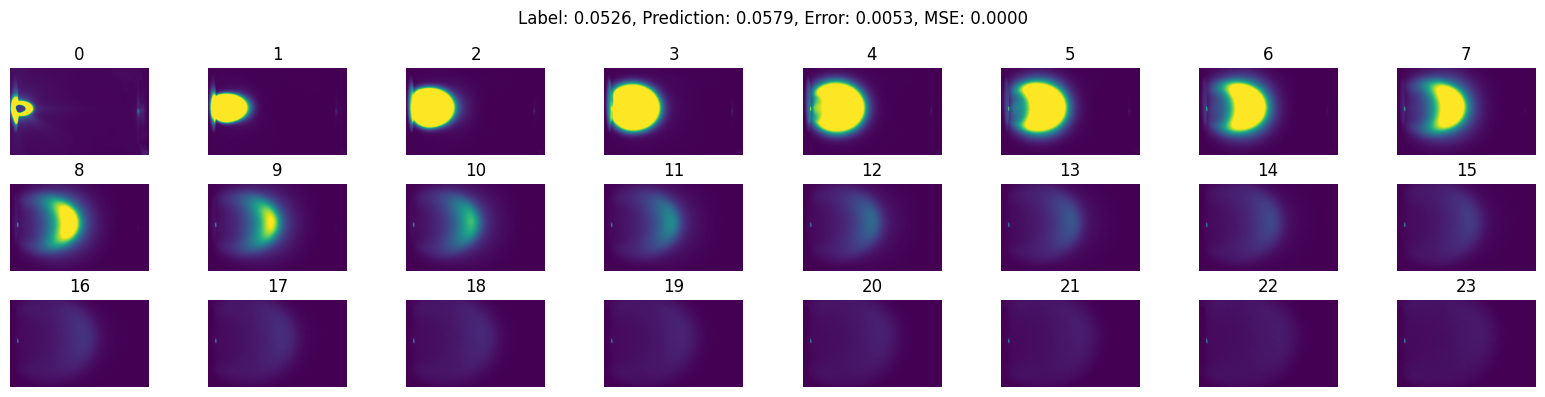

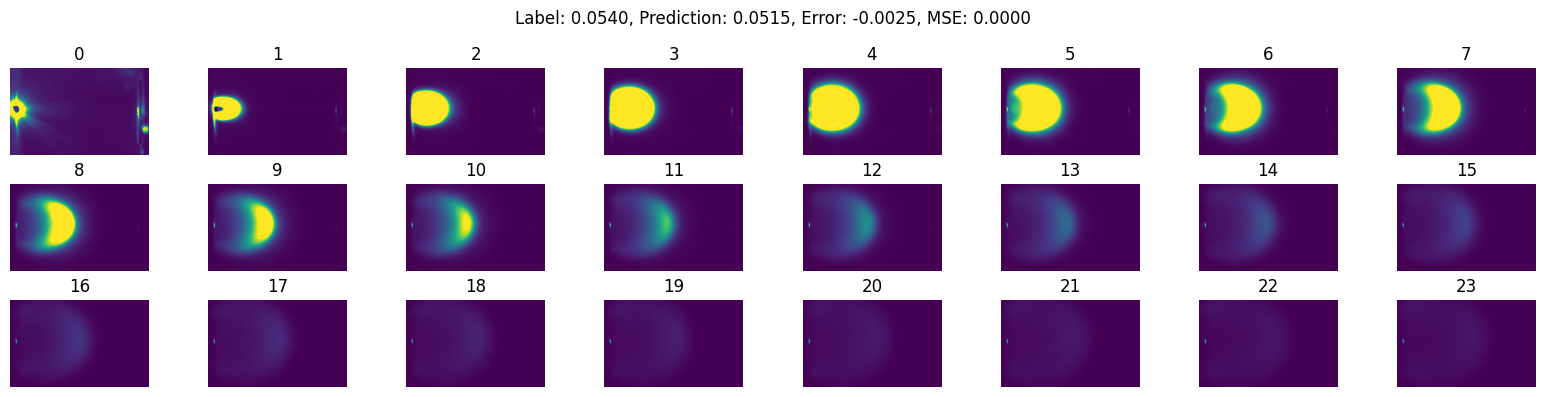

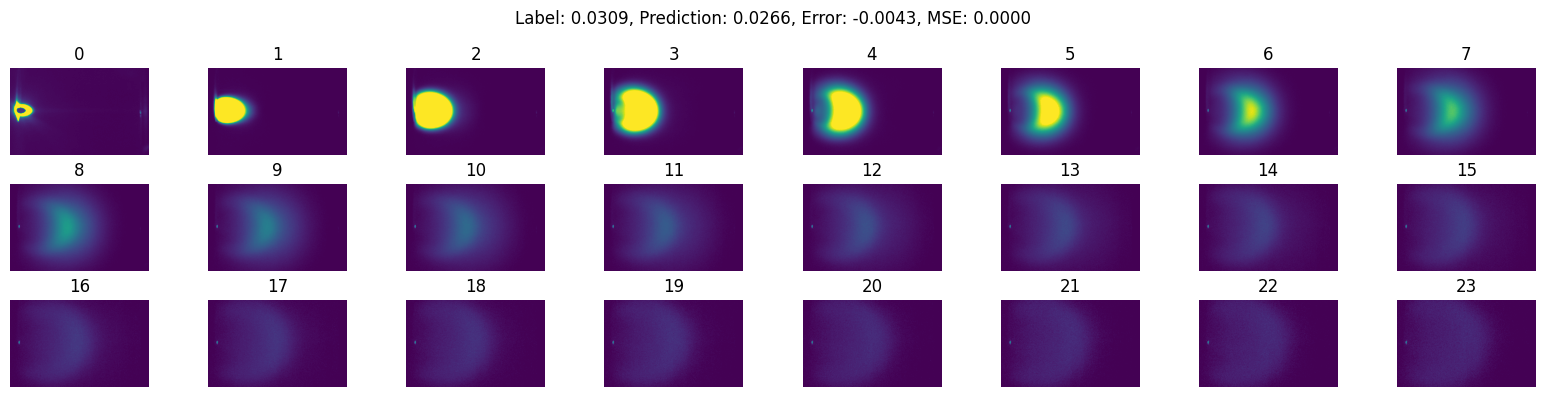

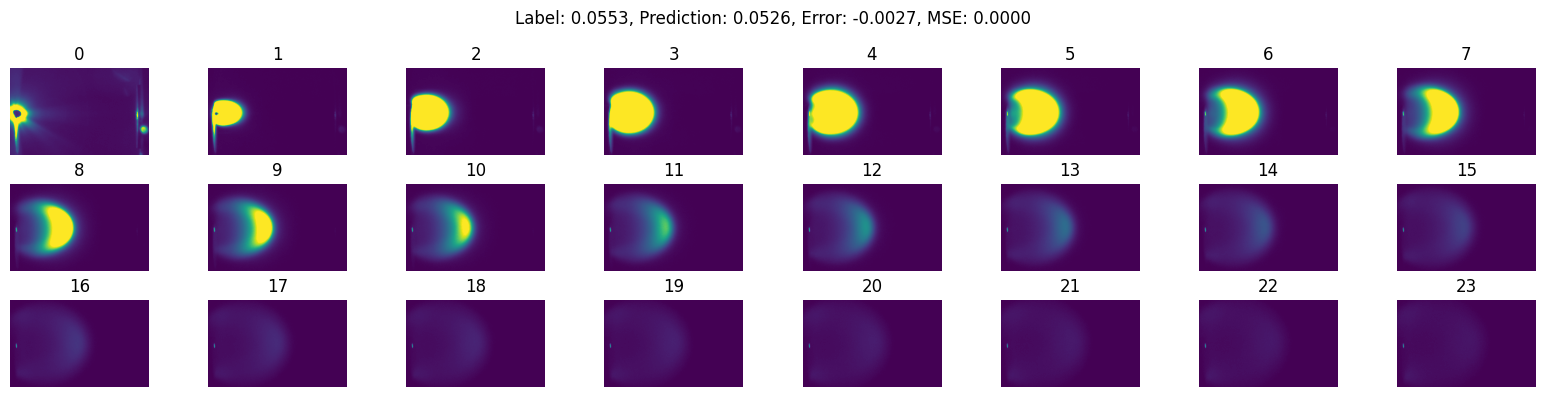

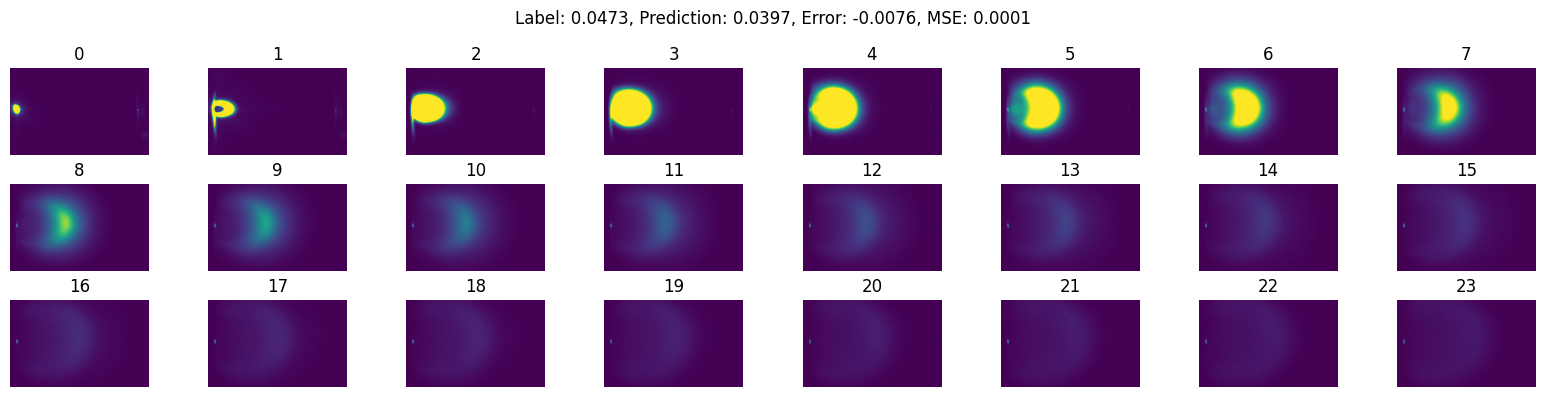

In [11]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(train_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
output = model(images)
images = images.squeeze().cpu().numpy()
print(images.shape, output.shape, labels.shape)

for i in range(len(images)):
    show_images(images[i,:24], title=f'Label: {labels[i].item():.4f}, Prediction: {output[i].item():.4f}, Error: {output[i].item()-labels[i].item():.4f}, MSE: {loss_func(output[i], labels[i]).item():.4f}')
    plt.show()

c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


(16, 24, 250, 400) torch.Size([16, 1]) torch.Size([16, 1])


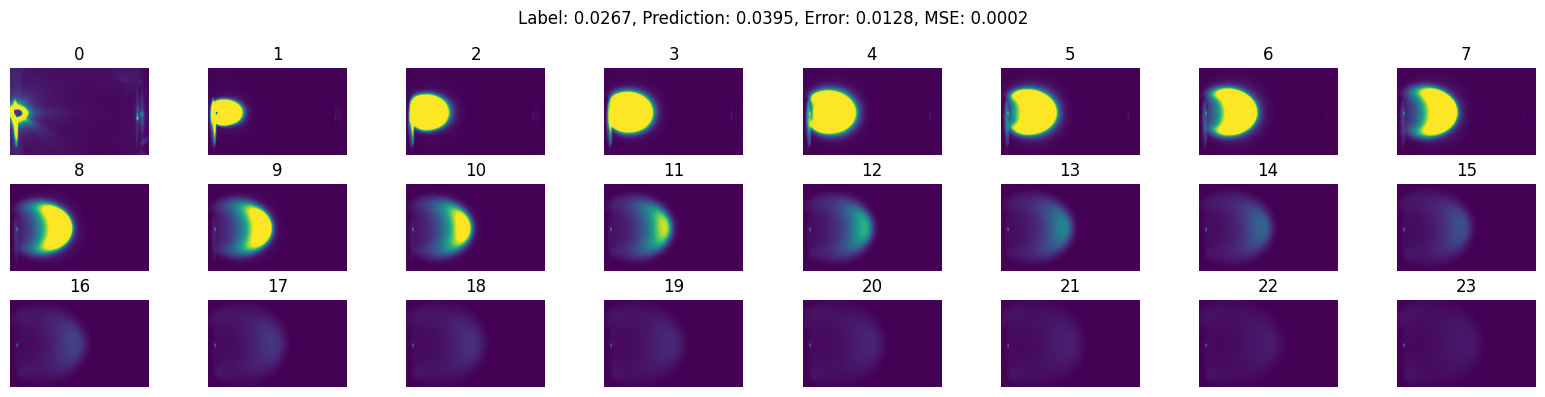

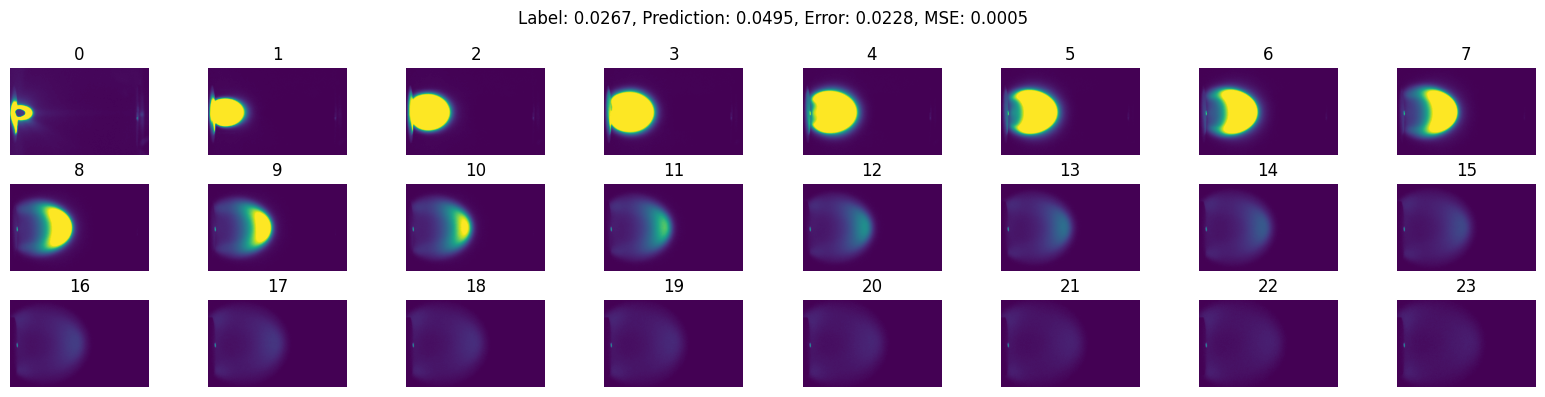

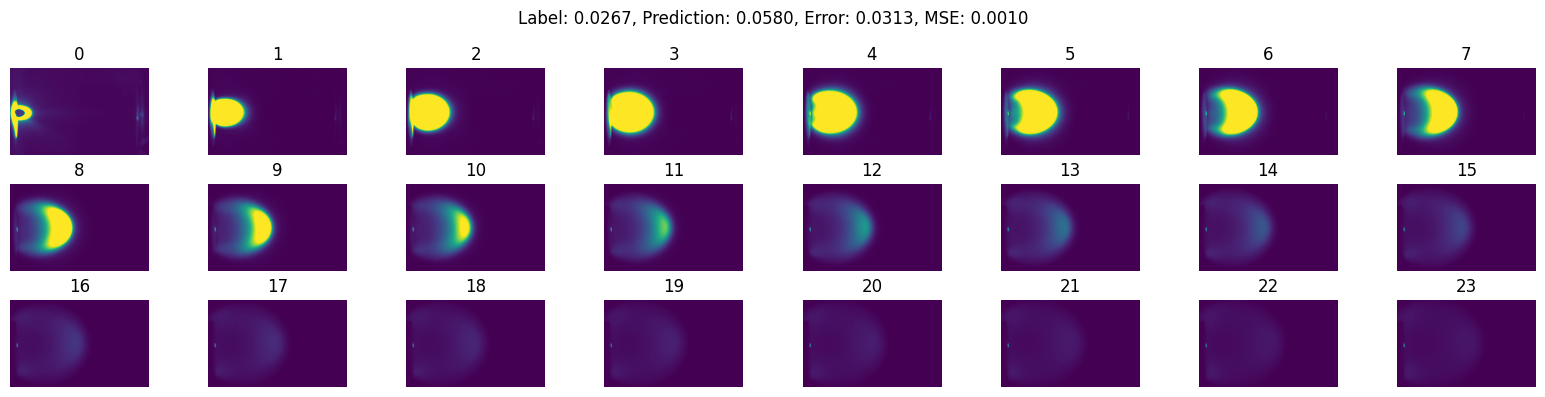

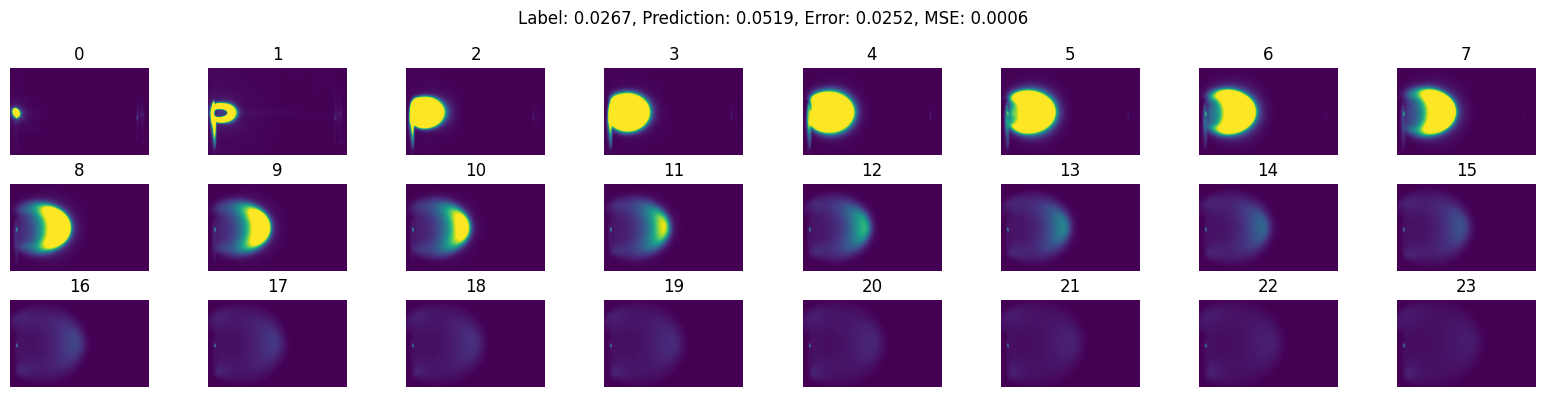

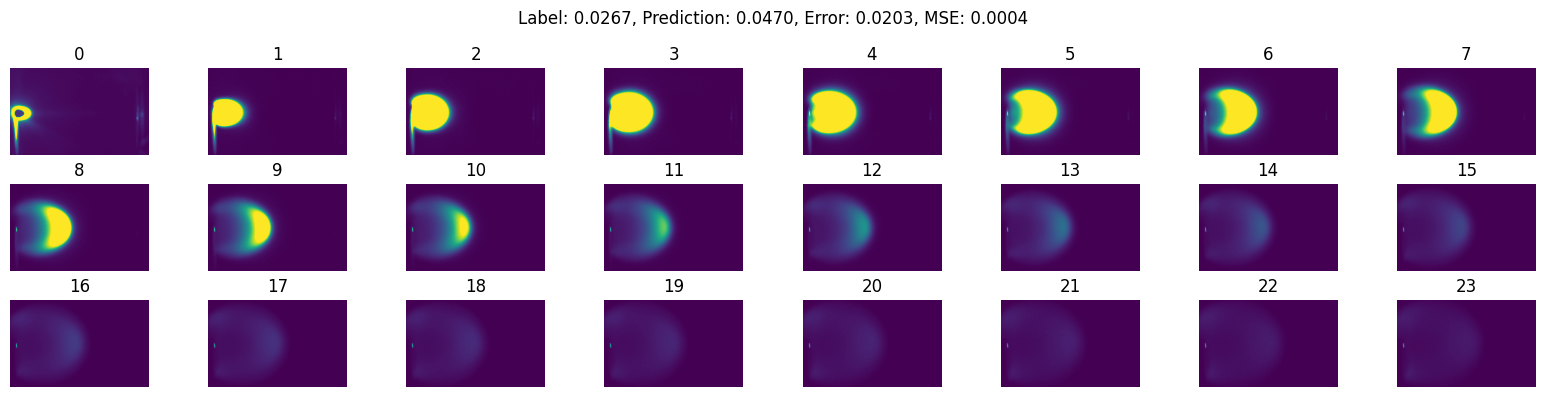

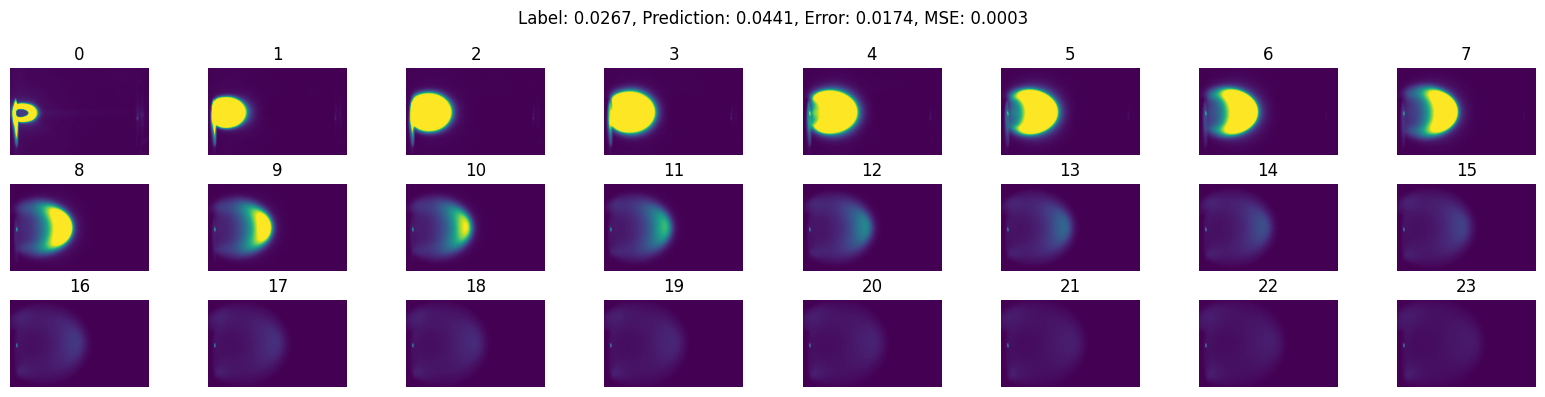

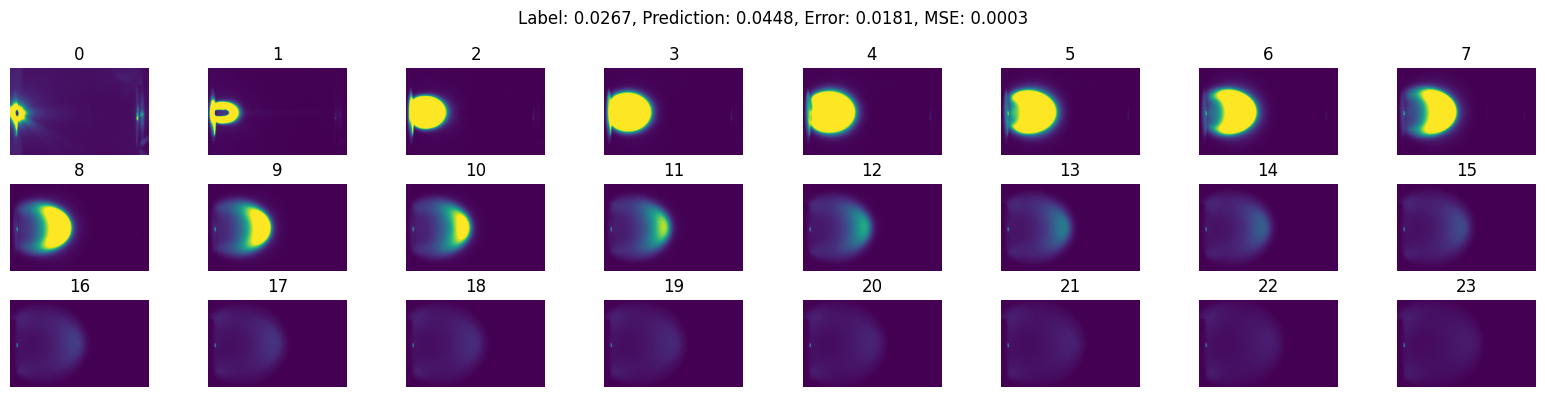

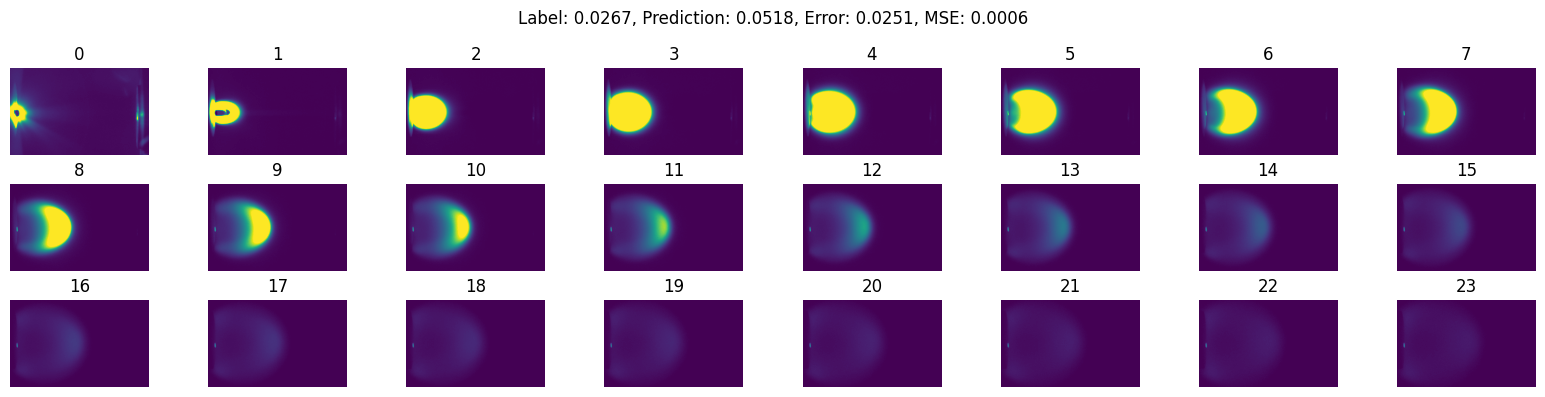

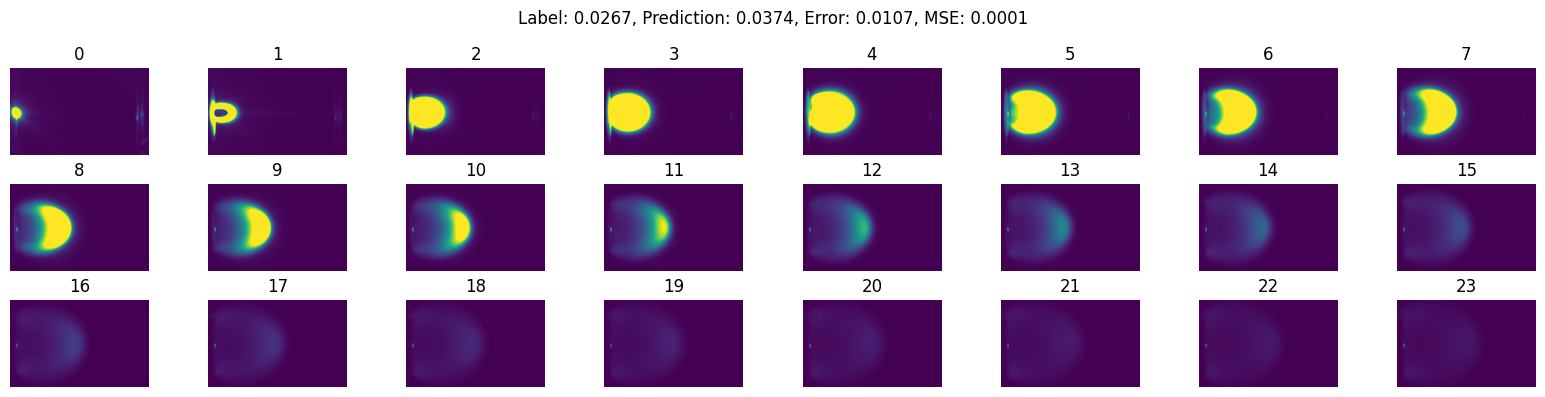

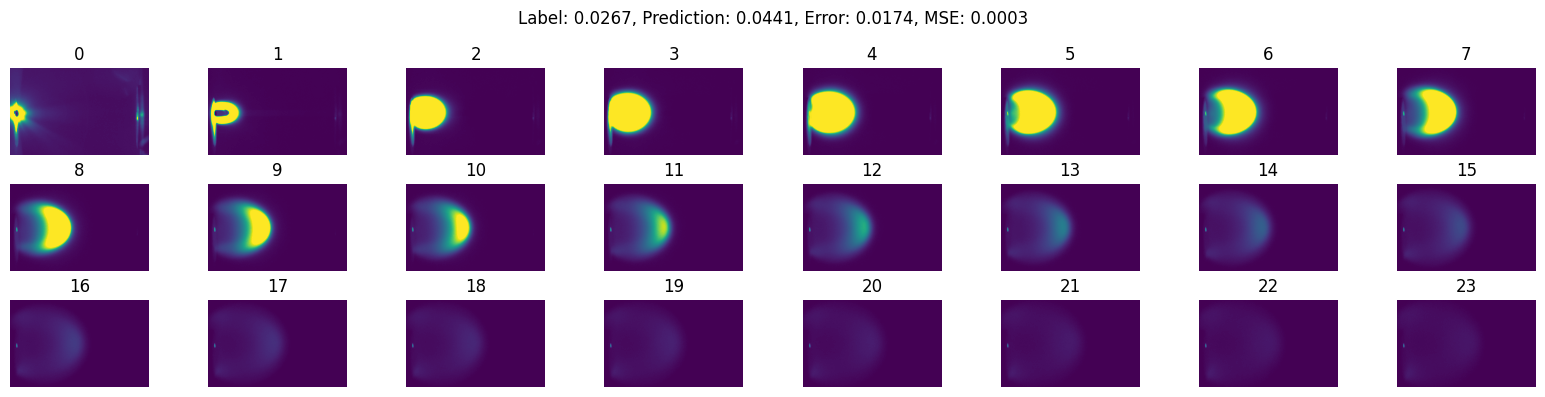

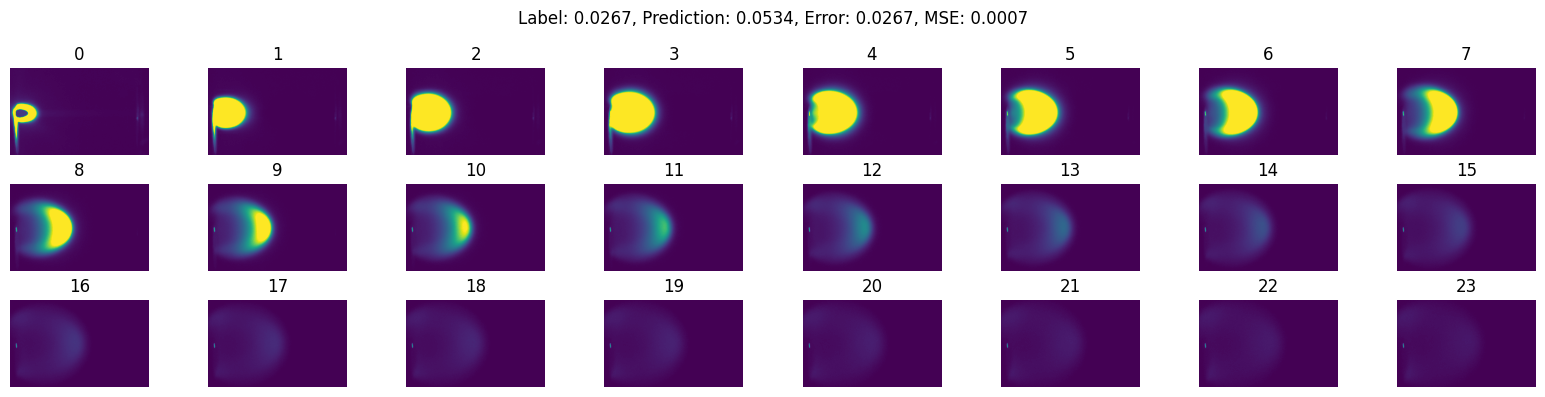

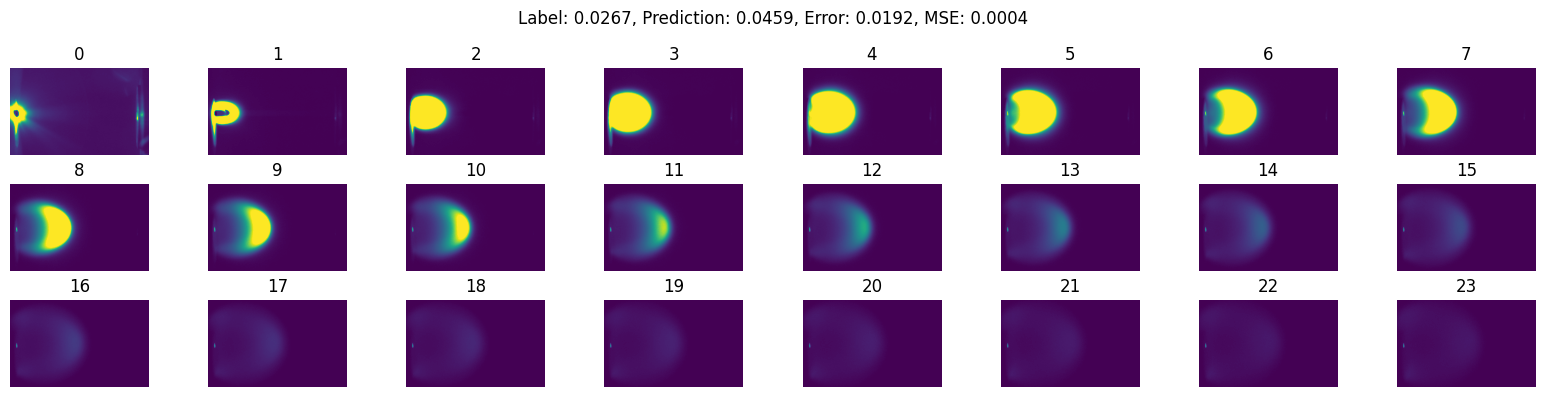

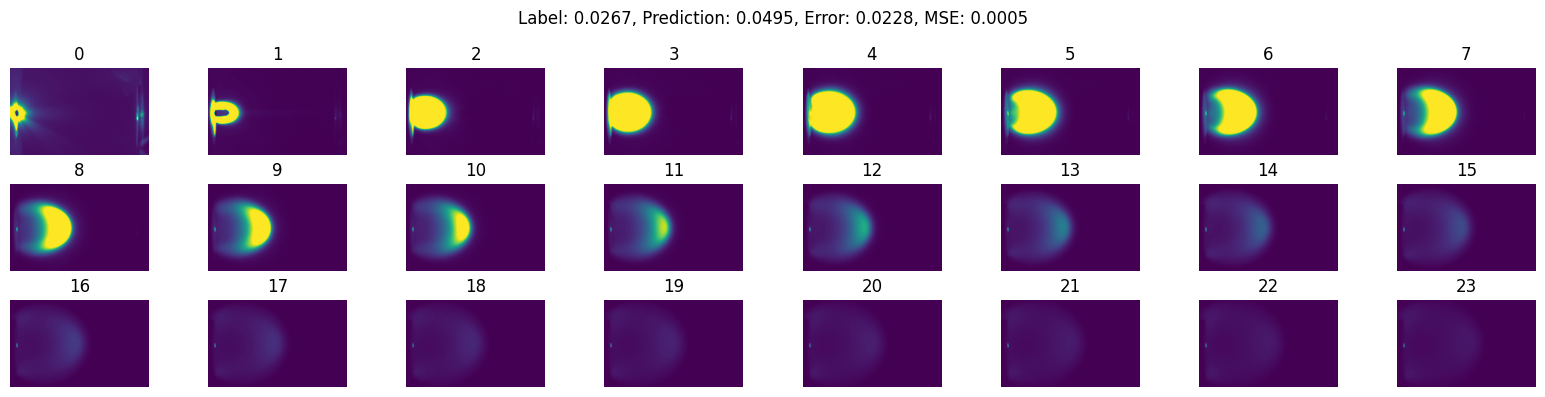

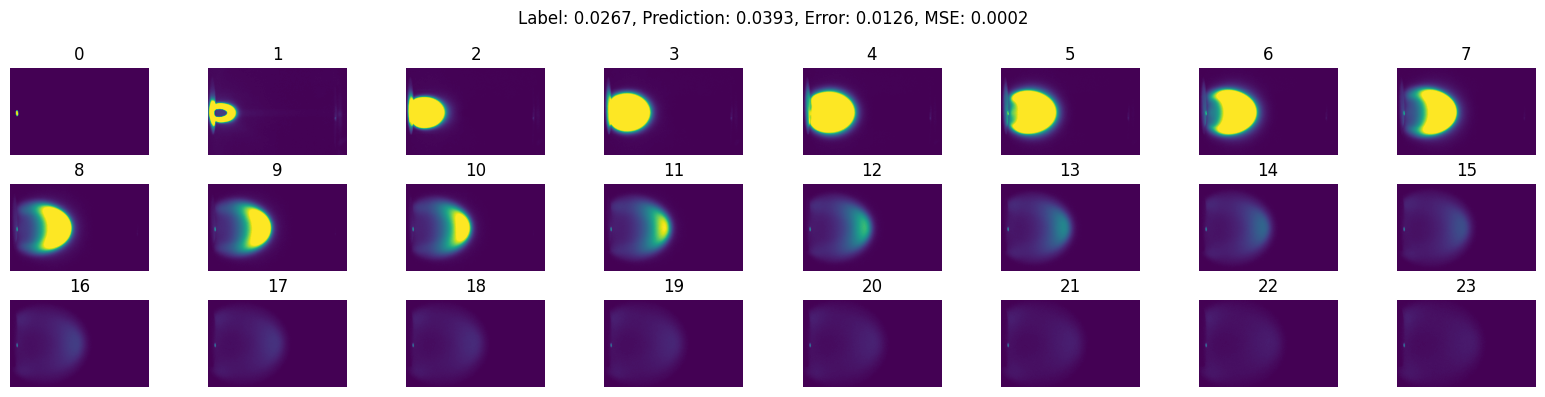

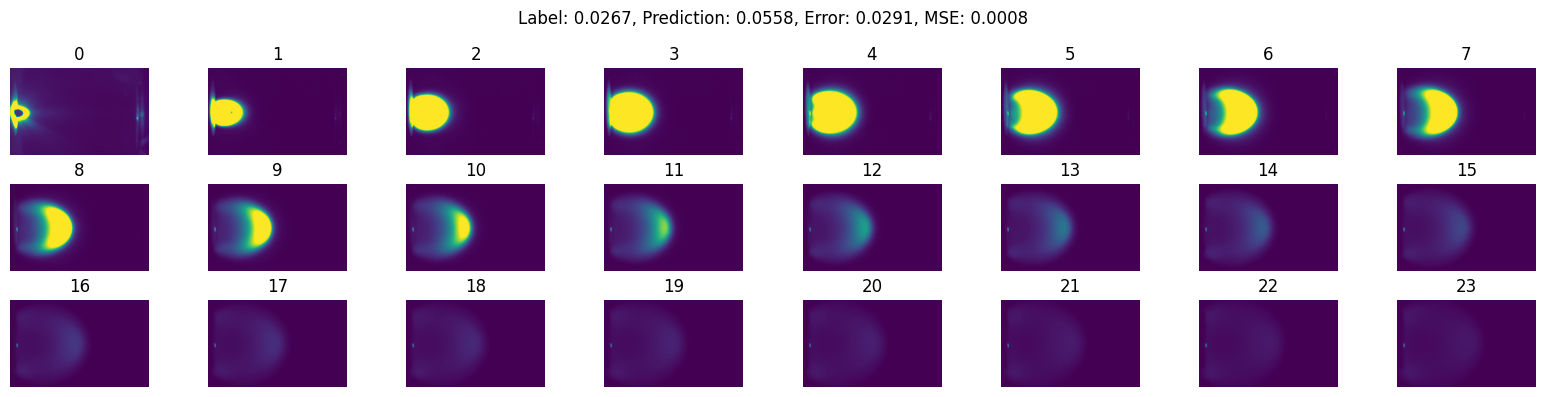

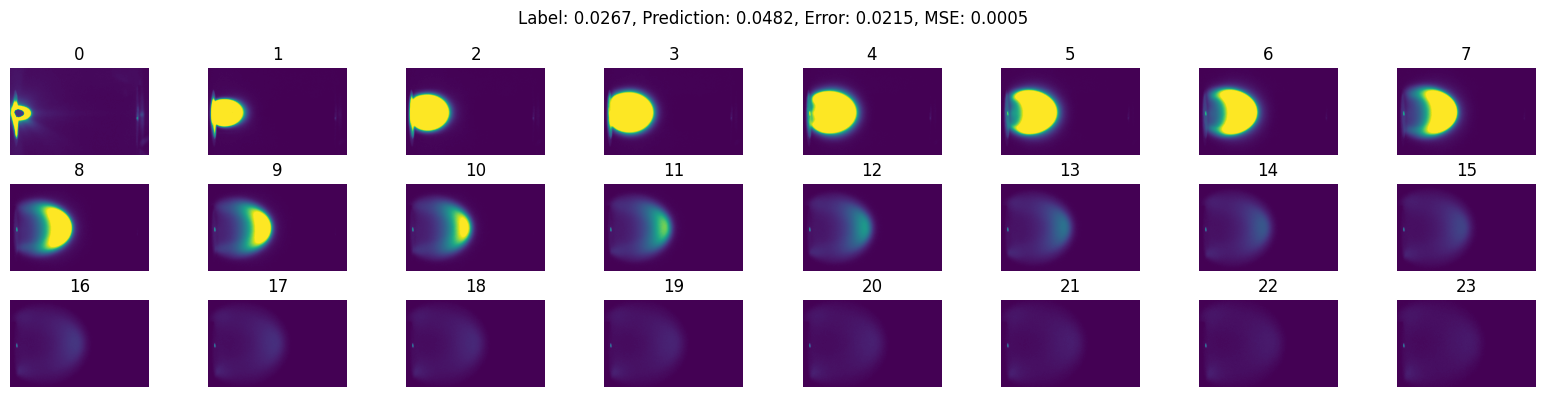

In [4]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(test_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
output = model(images)
images = images.squeeze().cpu().numpy()
print(images.shape, output.shape, labels.shape)

for i in range(len(images)):
    show_images(images[i,:24], title=f'Label: {labels[i].item():.4f}, Prediction: {output[i].item():.4f}, Error: {output[i].item()-labels[i].item():.4f}, MSE: {loss_func(output[i], labels[i]).item():.4f}')
    plt.show()